In [40]:
import jax
import numpy as np
from einops import rearrange
from jax import jit
from jax import numpy as jnp
from jax.nn import sigmoid
from matplotlib import dates
from matplotlib import pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from tueplots.constants.color import rgb

jax.config.update('jax_enable_x64', True)

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial', 'Liberation Sans']
})


##  Loading The data

In [41]:
from utils import *

In [53]:
# Data loading 
data = jnp.load("data_info.npz")
S = data["sird_data"][:, 0] / 1000
I = data["sird_data"][:, 1] / 1000
R = (data["sird_data"][:, 2] + data["sird_data"][:, 3]) / 1000

data_grid = jnp.array(data["data_grid"], dtype=int)
# print(data["date_range_x"].shape)
data_dates = data["date_range_x"][data_grid]

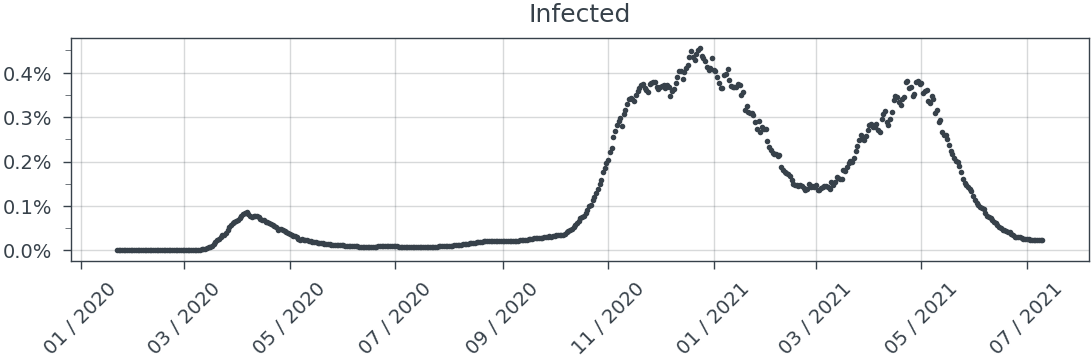

In [54]:
fig, ax = plt.subplots()
ax.plot(data_dates, I[data_grid], ".", color=rgb.tue_dark, lw=1, ms=2)
ax.set_title("Infected")
ax.xaxis.set_tick_params(rotation=45)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m / %Y"))
ax.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(0.001))
ax.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(0.0005))
ax.yaxis.set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%")
)
ax.grid(axis="both")

# plt.savefig("data.pdf")

In [12]:
# the data are dense, daily:
assert (data_grid[1:] - data_grid[:-1] == 1).all()

## Methods

In [13]:
from jax import jacrev


def ExtendedKalmanFilter(f: callable, h: callable, Q, R):
    """
    f: state transition function
        signature: f(x) -> x'
        where x: state vector
        with jacobian Fx: df/dx
    h: observation function
        signature: h(x) -> z
        where x: state vector
        with jacobian Hx: dh/dx
    """

    @jit
    def predict(m, P):
        m_ = f(m)
        F = jacrev(f)(m)
        P_ = F @ P @ F.T + Q
        return m_, P_

    @jit
    def update(m_, P_, z):
        z_ = h(m_)
        H = jacrev(h)(m_)
        S = H @ P_ @ H.T + R
        K = jnp.linalg.solve(S, H @ P_).T  # find K s.t. S @ K.T = H @ P_
        m = m_ + K @ (z - z_)
        P = P_ - K @ S @ K.T
        return m, P

    return predict, update

### Naïve Model:

In [14]:
# no drift, just diffusion
A, Q = lti_disc(F=jnp.zeros((1, 1)), L=jnp.eye(1) * 0.1, dt=1)

# observation model: We just observe once per day, the true I,
# up to Gaussian noise of variance 1 / average_number_of_cases

total_population = 80_000_000
variance = 0.002**4 * total_population / total_population

ALPHA = 0.02 #1e-6 # 0.02
def h(x):
    return x

def h_inv(x):
    return x

f = lambda x: A @ x

R = jnp.eye(1) * variance

predict, update = ExtendedKalmanFilter(f, h, Q, R)

In [15]:
# in this simple setup, we get away without a prior
I0 = h_inv(I_data[0])
m0 = jnp.array([I0])
P0 = R

m = m0
P = P0
ms = [m]
Ps = [P]
for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, I_data[t])
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)


ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

(-0.005, 0.005)

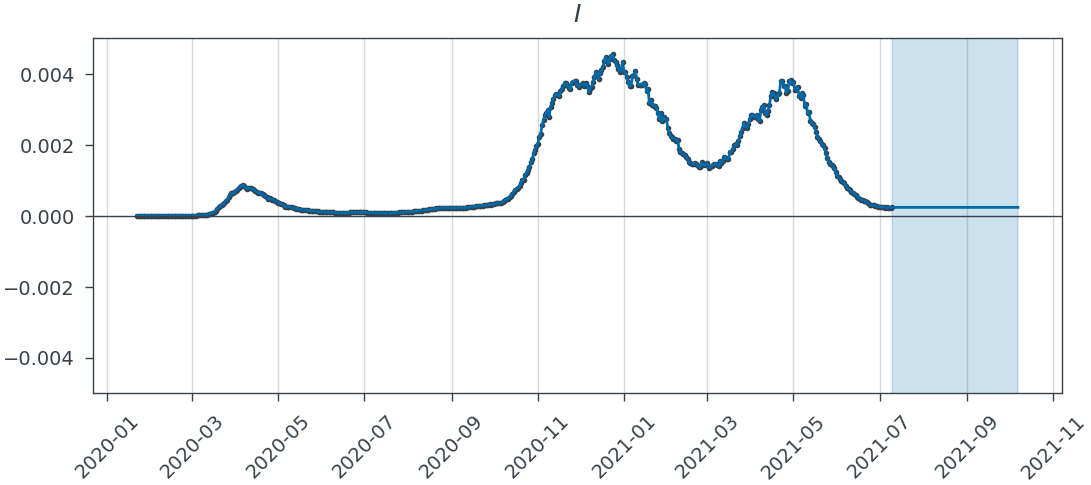

In [16]:
fig, ax = plot_state_raster(Ps=Ps, ms = ms, h=h, num_derivatives= 1, num_states=1, states = ["I"])
ax[0,0].set_ylim(-0.005, 0.005)
# plt.savefig("naive.pdf")

### Mapping to a latent space for physically meaningful representations

In [17]:
# no drift, just diffusion
A, Q = lti_disc(F=jnp.zeros((1, 1)), L=jnp.eye(1) * 0.2, dt=1)

# observation model: We just observe once per day, the true I,
# up to Gaussian noise of variance 1 / average_number_of_cases

total_population = 80_000_000
variance = 1e-6**2

ALPHA = 1e-6 # 0.02 # 1e-6
def h(x):
    return (1 + ALPHA) * jax.nn.sigmoid(x) - ALPHA / 2

def h_inv(y):
    z = (y + ALPHA / 2) / (1 + ALPHA)
    return jnp.log(z) - jnp.log(1 - z)

f = lambda x: A @ x

R = jnp.eye(1) * variance

predict, update = ExtendedKalmanFilter(f, h, Q, R)

To model functions $S,I,R$ constrained to the simplex $[0,1]$, we consider a latent Gaussian process $\tilde{I}$ taking values $\in \Re$, and use a softened sigmoid transformation $I = h(\tilde{I})$.

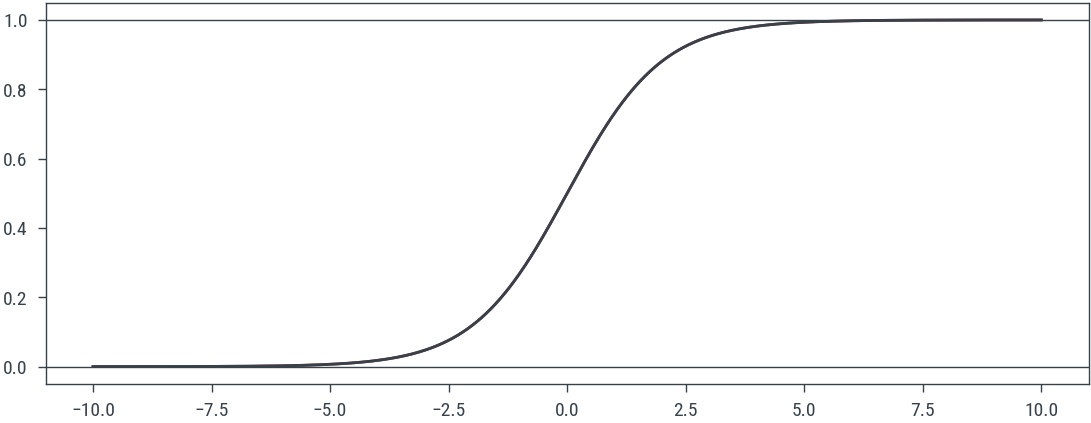

In [18]:
plt.rcParams.update(bundles.beamer_moml(rel_height=0.7))
fig, ax = plt.subplots()
tmp_xplot = jnp.linspace(-10,10,1000)
ax.plot(tmp_xplot, h(tmp_xplot), label="h")
ax.plot(h_inv(h(tmp_xplot)),h(tmp_xplot), label="h_inv")
ax.axhline(0, color=rgb.tue_dark, lw=0.5)
ax.axhline(1, color=rgb.tue_dark, lw=0.5)
# plt.savefig("h.pdf")

In [19]:
# in this simple setup, we get away without a prior
I0 = h_inv(I_data[0])
m0 = jnp.array([I0])
P0 = R

m = m0
P = P0
ms = [m]
Ps = [P]
for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, I_data[t])
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)


ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

(-0.001, 0.006)

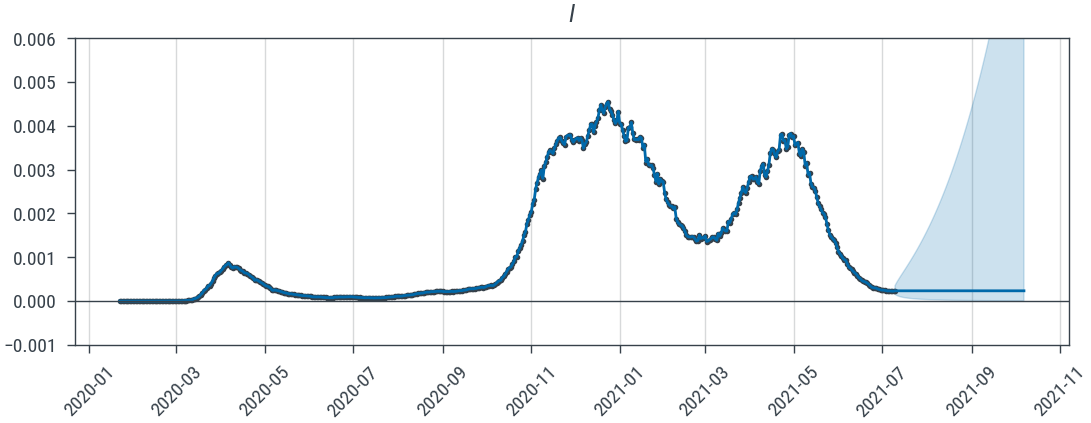

In [20]:
fig, ax = plot_state_raster(Ps=Ps, ms = ms, h=h, num_derivatives= 1, num_states=1, states = ["I"])
ax[0,0].set_ylim(-0.001, 0.006)
# plt.savefig("ekf_latent_spaces.pdf")

### Differentiable Paths

We encode the Information that e.g. $\dot I(t)$ is the derivative of $I(t)$ into $F$ and $L$
$$
x(t) = \begin{bmatrix} I(t) \\ \dot I(t) \\ \ddot I(t) \end{bmatrix}
$$

$$
\mathrm{d} x(t)
= \begin{bmatrix}  \mathrm{d} I(t) \\  \mathrm{d} \dot I(t) \\  \mathrm{d} \ddot I(t) \end{bmatrix}
=  \underbrace{\begin{bmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}}_{= F}
\cdot \begin{bmatrix} I(t) \\ \dot I(t) \\ \ddot I(t) \end{bmatrix} \mathrm{d} t +
\underbrace{\begin{bmatrix} 0 \\ 0 \\ \sigma_I \end{bmatrix}}_{= L}
\mathrm{d} \omega =
\begin{bmatrix}  \dot I(t) \mathrm{d} t \\ \ddot I(t) \mathrm{d} t \\ \sigma_I \mathrm{d} \omega \end{bmatrix}
$$


In [21]:
num_states = 1
num_derivatives = 3
F, L, A, Q = build_A_Q(num_states = num_states, num_derivatives= num_derivatives, sigma =  [4e-6])

def h_state(X):
    return h(X[(0,),]) #weird stuff so input stays array

f = lambda x: A @ x

predict, update = ExtendedKalmanFilter(f, h_state, Q, R)

In [22]:
# Use the Kalman filter
m0 = jnp.zeros(num_derivatives)
# Initialize S,I,R = 1,I[0],0
m0 = m0.at[0].set(I0)
m0 = m0.reshape((num_derivatives,))
P0 = jnp.zeros((num_derivatives, num_derivatives))
P0 = P0.reshape((num_derivatives, num_derivatives))
P0 = P0.at[2,2].set(1**2)
P0 = P0.reshape((num_derivatives, num_derivatives))

# Prior
m_, P_ = m0, P0
m, P = update(m_, P_, jnp.array(I0))
ms = [m]
Ps = [P]

for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, I_data[t])
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)

ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

Plotting requires a bit of care:

Our latent dynamics model represents $\tilde{I}, \dot{\tilde{I}}, \ddot{\tilde{I}}$, and so on. But we want to plot $I,\dot{I}$, etc. Note that
$$ \dot{I} = \frac{d h(\tilde{I(t)})}{dt} = \frac{d h(\tilde{I})}{d \tilde{I}}\frac{d \tilde{I}}{dt} = \frac{d h(\tilde{I})}{d \tilde{I}} \cdot \dot{I}$$
and 
$$ \ddot{I} = \frac{d^2 h(\tilde{I(t)})}{dt^2} = \frac{d}{dt} \frac{d h(\tilde{I})}{d \tilde{I}} \cdot \dot{I} = \frac{d h(\tilde{I})}{d \tilde{I}} \cdot \ddot{I}$$
(because $h$ is time-independent)

In [23]:
def h_plot(X):
    # X.shape = (n, num_states, num_derivatives)
    J = jacrev(
        h,
    )(
        X
    )
    return jnp.array(
        [
            h(X[0]),
            J[0, 0] * X[1],
            J[0, 0] * X[2],
        ]
    )

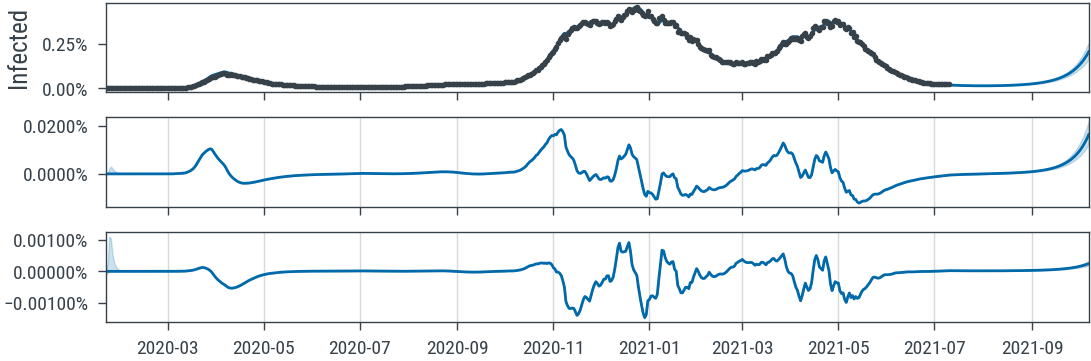

In [24]:
num_derivatives = 3
n_plot = len(t_plot)
std_r = jnp.sqrt(Ps.reshape(n_plot, num_derivatives, num_derivatives))
std = jnp.sqrt(jnp.diagonal(Ps, 0, 1, 2))

ms_h = jax.vmap(h_plot)(ms)
lower = jax.vmap(h_plot)(ms - 2 * std)
upper = jax.vmap(h_plot)(ms + 2 * std)

ms_r = ms_h.reshape((n_plot, num_derivatives))
lower = lower.reshape((n_plot, num_derivatives))
upper = upper.reshape((n_plot, num_derivatives))

plt.rcParams.update(bundles.beamer_moml(rel_height=0.6))
fig, axs = plt.subplots(3, 1, sharex=True)
for i in range(num_derivatives):
    ax = axs[i]
    ax.plot(t_plot, ms_r[:, i], label="I", color=rgb.tue_blue, lw=1)
    ax.fill_between(
        t_plot,
        lower[:, i],
        upper[:, i],
        color=rgb.tue_blue,
        alpha=0.2,
    )

    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    ax.grid(axis="x")

ax = axs[0]
ax.plot(data_dates, I_data, ".", color=rgb.tue_dark, lw=1, ms=2)
ax.set_ylabel("Infected")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
ax.grid(axis="x")


ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(t_plot[0], t_plot[-1]);

# plt.savefig("differentiable_paths.pdf")


## 2. State Space Model

Ok, that was too easy. Let's generalize to a real *state space model*. 

We will consider the three states $[S(t),I(t),R(t)]$, *and* their first two derivatives $[\dot{S}(t),\dot{I}(t),\dot{R}(t)]$ and $[\ddot{S}(t),\ddot{I}(t),\ddot{R}(t)]$. As above, we need to define the SDE in terms of $F,L$.

In [25]:
num_states = 3
num_derivatives = 3
F, L, A, Q = build_A_Q(num_states = num_states, num_derivatives= num_derivatives, sigma =  [1e-6, 4e-6, 1e-6])

def h_state(X):
    return h(X[(3,),]) #weird stuff so input stays array

f = lambda x: A @ x

predict, update = ExtendedKalmanFilter(f, h_state, Q, R)

In [26]:
# Use the Kalman filter

m0 = jnp.zeros((num_states, num_derivatives))
# Initialize S,I,R = 1,I[0],0
m0 = m0.at[0, 0].set(h_inv(1))
m0 = m0.at[1, 0].set(I0)
m0 = m0.at[2, 0].set(h_inv(0))
m0 = m0.reshape((num_states * num_derivatives,))
P0 = jnp.zeros((num_states * num_derivatives, num_states * num_derivatives))
P0 = P0.reshape((num_states, num_derivatives, num_states, num_derivatives))
P0 = P0.at[1, 2, 1, 2].set(1**2)
P0 = P0.reshape((num_states * num_derivatives, num_states * num_derivatives))

# Prior
m_, P_ = m0, P0
m, P = update(m_, P_, jnp.array(I0))
ms = [m]
Ps = [P]

for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, I_data[t])
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)

ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

In [27]:
def h_plot(X):
    # X.shape = (n, num_states, num_derivatives)
    J = jacrev(h, )(X[(0,3,6),])
    return jnp.array([
        h(X[0]), J[0,0] * X[1], J[0,0] * X[2],
        h(X[3]), J[1,1] * X[4], J[1,1] * X[5],
        h(X[6]), J[2,2] * X[7], J[2,2] * X[8]
         ])

ms.shape = (626, 9)


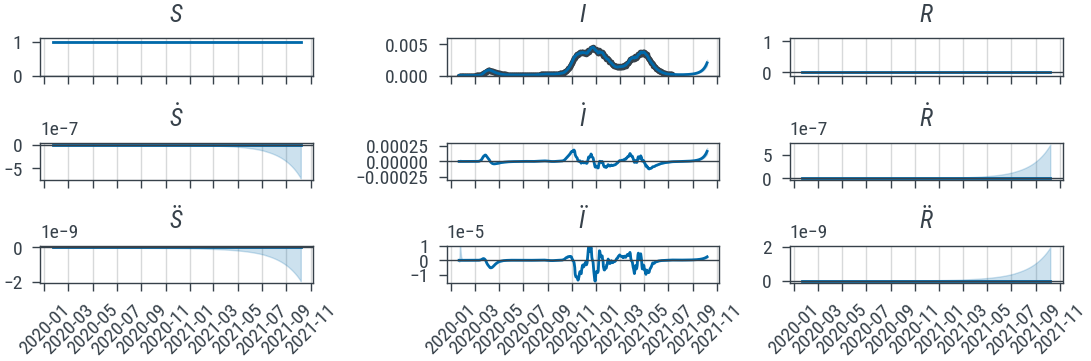

In [28]:
print(f"{ms.shape = }")
fig, ax = plot_state_raster(Ps=Ps, ms = ms, h=h_plot, num_derivatives= 3, num_states=3, states = ["S", "I", "R"])
ax[0,0].set_ylim((0, 1.1))
ax[0,1].set_ylim((0, 0.005))
ax[0,2].set_ylim((-0.1, 1.1))
ax[0,1].set_ylim((0, 6e-3))
ax[1,1].set_ylim((-3e-4, 3e-4))
plt.show()

##  3. Total Population is constant
 Add one more observation per time step encoding $S(t) + I(t) + R(t) = 1$ (Note this is a *linear* constraint, i.e. $\N(0; Hx(t) - 1,0)$ with `H[0,:,0]=1`)

In [29]:
def h_state_and_population(X):
    state = h(X[(3,),]) #weird stuff so input stays array
    population = jnp.array(h(X[(0,3,6),]).sum(axis=0))[None,]
    return jnp.concatenate([state, population], axis=0)

R = jnp.eye(2)
R = R.at[0, 0].set(variance)
R = R.at[1, 1].set(1e-8)

predict, update = ExtendedKalmanFilter(f, h_state_and_population, Q, R)

In [30]:
# Use the Kalman filter

m0 = jnp.zeros((num_states, num_derivatives))
# Initialize S,I,R = 1,I[0],0
m0 = m0.at[0, 0].set(h_inv(1))
m0 = m0.at[1, 0].set(I0)
m0 = m0.at[2, 0].set(h_inv(0))
m0 = m0.reshape((num_states * num_derivatives,))
P0 = jnp.zeros((num_states * num_derivatives, num_states * num_derivatives))
P0 = P0.reshape((num_states, num_derivatives, num_states, num_derivatives))
P0 = P0.at[1, 2, 1, 2].set(1**2)
P0 = P0.reshape((num_states * num_derivatives, num_states * num_derivatives))

# Prior
m_, P_ = m0, P0
m, P = update(m_, P_, jnp.array([I0,1]))
ms = [m]
Ps = [P]

for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, jnp.array([I_data[t],1]))
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)

ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

ms.shape = (626, 9)


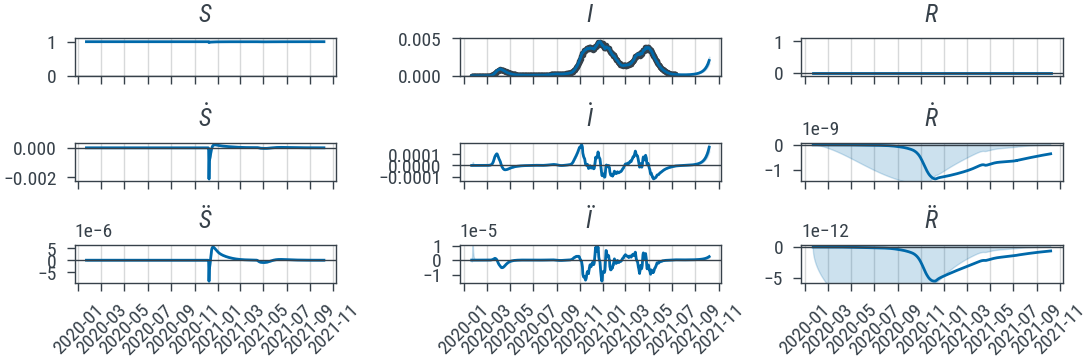

In [31]:
print(f"{ms.shape = }")
fig, ax = plot_state_raster(Ps=Ps, ms = ms, h=h_plot, num_derivatives= 3, num_states=3, states = ["S", "I", "R"])
ax[0,0].set_ylim((0, 1.1))
ax[0,1].set_ylim((0, 0.005))
ax[0,2].set_ylim((-0.1, 1.1))
plt.show()

## Add ODE Information
Add the ODE information: Namely the information operator $\delta(h(x))$ with $h(x) = \dot{x}(t) - f(x(t),\beta(t))$ where
$$ f(x(t),\beta(t))  = \begin{pmatrix} -\beta(t) S(t) I(t) \\ +\beta(t)S(t)I(t) - \nu I(t) \\ + \nu I(t) \end{pmatrix} $$
* For this to work, also add one more states to model $\beta(t)$. Typical model for $\beta(t)$ may be a integrated Wiener process

In [32]:
def ode(S, I, R, beta):
    nu = 0.1
    return jnp.array([-beta * S * I, beta * S * I - nu * I, nu * I])

num_states = 4
num_derivatives = 3
# F, L, A, Q = build_A_Q(num_states = num_states, num_derivatives = num_derivatives, sigma = [6e-4, 6e-6, 6e-4, 1e-3])
F, L, A, Q = build_A_Q(num_states = num_states, num_derivatives = num_derivatives, sigma = [1e-4, 1e-4, 1e-4, 1e-4])

In [33]:
def h_ODE(X):
    # we construct the states that go into the ODE:
    J = jacrev(
        h,
    )(
        X[(0, 3, 6),] # S, I, R
    )
    Xdot = jnp.array([J[0, 0] * X[1], J[1, 1] * X[4], J[2, 2] * X[7]])
    ODEinputs = [h(X[0]), h(X[3]), h(X[6])]
    return Xdot - ode(*ODEinputs)

In [34]:
def h_ODE_with_beta(X):
    # we construct the states that go into the ODE:
    J = jacrev(
        h,
    )(
        X[(0, 3, 6),] # S, I, R
    )
    Xdot = jnp.array([J[0, 0] * X[1], J[1, 1] * X[4], J[2, 2] * X[7]])
    ODEinputs = [h(X[0]), h(X[3]), h(X[6]), h(X[9])]
    Information_operator = Xdot - ode(*ODEinputs)
    return jnp.concatenate([state, Information_operator], axis=0)

In [35]:
def h_state_and_population_and_ODE(X):
    state = h(X[(3,),])  # weird stuff so input stays array
    population = jnp.array(h(X[(0, 3, 6),]).sum(axis=0))[None,]

    # we construct the states that go into the ODE:
    J = jacrev(
        h,
    )(
        X[(0, 3, 6),]
    )
    Xdot = jnp.array([J[0, 0] * X[1], J[1, 1] * X[4], J[2, 2] * X[7]])
    ODEinputs = [h(X[0]), h(X[3]), h(X[6]), h(X[9])]
    Information_operator = Xdot - ode(*ODEinputs)
    return jnp.concatenate([state, population, Information_operator], axis=0)
    # return jnp.concatenate([state, Information_operator], axis=0)


R = jnp.eye(5)
R = R.at[0, 0].set(variance)
for i in range(1, 5):
    R = R.at[i, i].set(1e-8)

f = lambda x: A @ x

predict, update = ExtendedKalmanFilter(f, h_state_and_population_and_ODE, Q, R)

In [36]:
# Use the Kalman filter
m0 = jnp.zeros((num_states, num_derivatives))
# Initialize S,I,R = 1,I[0],0
m0 = m0.at[0, 0].set(h_inv(1))
m0 = m0.at[1, 0].set(I0)
m0 = m0.at[2, 0].set(h_inv(0))
m0 = m0.at[3, 0].set(h_inv(0.5))
m0 = m0.reshape((num_states * num_derivatives,))
P0 = jnp.zeros((num_states * num_derivatives, num_states * num_derivatives))
P0 = P0.reshape((num_states, num_derivatives, num_states, num_derivatives))
P0 = P0.at[1, 2, 1, 2].set(1**2) # uncertainty in I
P0 = P0.at[3, 2, 3, 2].set(2e-1**2) # uncertainty in beta
P0 = P0.reshape((num_states * num_derivatives, num_states * num_derivatives))
# P0 = P0.at[9, 9].set(1)
# P0 = P0.at[10, 10].set(1)
# P0 = P0.at[11, 11].set(1)

# Prior
m_, P_ = m0, P0
m, P = update(m_, P_, jnp.array([I0,1,0,0,0]))
ms = [m]
Ps = [P]

for t in range(1, n):
    # predict:
    m_, P_ = predict(m, P)
    # update:
    m, P = update(m_, P_, jnp.array([I_data[t],1,0,0,0]))
    ms.append(m)
    Ps.append(P)

# afterward, predict a bit into the future:

for t in range(n, n + 3 * 30):
    m, P = predict(m, P)
    ms.append(m)
    Ps.append(P)

ms = jnp.stack(ms)
Ps = jnp.stack(Ps)

In [37]:
def h_plot_with_beta(X):
    # X.shape = (n, num_states, num_derivatives)
    J = jacrev(
        h,
    )(
        X[(0, 3, 6, 9),]
    )
    return jnp.array(
        [
            h(X[0]),
            J[0, 0] * X[1],
            J[0, 0] * X[2],
            h(X[3]),
            J[1, 1] * X[4],
            J[1, 1] * X[5],
            h(X[6]),
            J[2, 2] * X[7],
            J[2, 2] * X[8],
            h(X[9]),
            J[3, 3] * X[10],
            J[3, 3] * X[11],
        ]
    )

ms.shape = (626, 12)


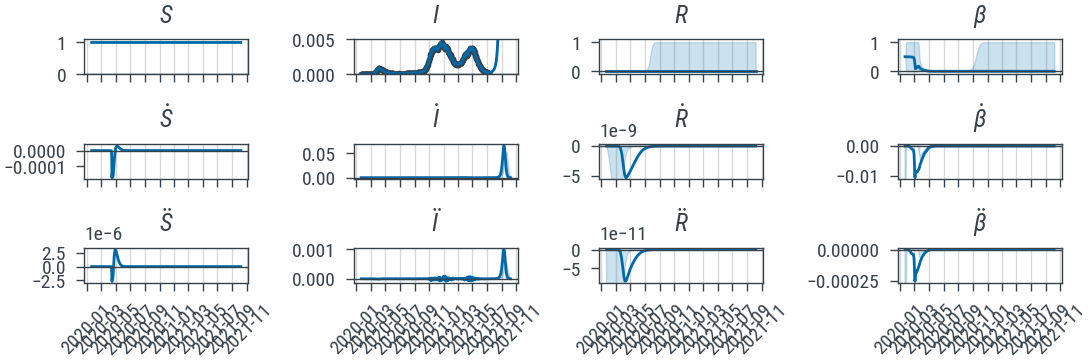

In [38]:
print(f"{ms.shape = }")
fig, ax = plot_state_raster(Ps=Ps, ms = ms, h=h_plot_with_beta, num_derivatives= 3, num_states=4, states = ["S", "I", "R", r"\beta"])
ax[0,0].set_ylim((0, 1.1))
ax[0,1].set_ylim((0, 0.005))
ax[0,2].set_ylim((-0.1, 1.1))
ax[0,3].set_ylim((-0.1, 1.1))
plt.show()
# plt.savefig("Covid_filter.pdf")

(0.0, 0.007)

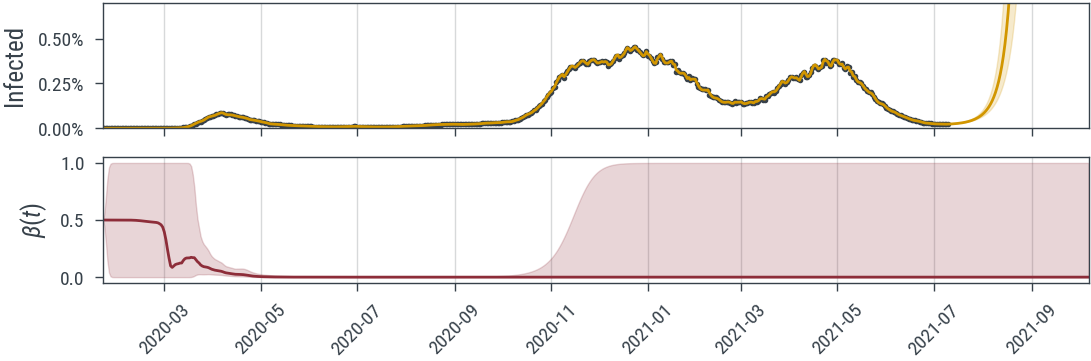

In [39]:
num_states = 4
num_derivatives = 3
n_plot = len(t_plot)
std_r = jnp.sqrt(
    Ps.reshape(n_plot, num_states, num_derivatives, num_states, num_derivatives)
)
std = jnp.sqrt(jnp.diagonal(Ps, 0, 1, 2))

ms_h = jax.vmap(h)(ms)
lower = jax.vmap(h)(ms - 2 * std)
upper = jax.vmap(h)(ms + 2 * std)

ms_r = ms_h.reshape((n_plot, num_states, num_derivatives))
lower = lower.reshape((n_plot, num_states, num_derivatives))
upper = upper.reshape((n_plot, num_states, num_derivatives))

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
ax.plot(data_dates, I_data, ".", color=rgb.tue_dark, lw=1, ms=2)
ax.plot(t_plot, ms_r[:, 1, 0], label="I", color=rgb.tue_orange, lw=1)
ax.fill_between(
    t_plot,
    lower[:, 1, 0],
    upper[:, 1, 0],
    color=rgb.tue_orange,
    alpha=0.2,
)
ax.set_ylabel("Infected")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
ax.grid(axis="x")

ax = axs[1]
ax.plot(t_plot, ms_r[:,4,0], label=r"$\beta$", color=rgb.tue_red, lw=1)
ax.fill_between(
    t_plot,
    lower[:, 4, 0],
    upper[:, 4, 0],
    color=rgb.tue_red,
    alpha=0.2,
)
ax.grid(axis="x")
ax.set_ylabel(r"$\beta(t)$")

ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(t_plot[0], t_plot[-1])

axs[0].set_ylim((0, 0.007))
# plt.savefig("Covid_filter.pdf")